In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load ETFs' data
df = pd.read_csv("S&P data.csv")

# TODO
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.drop(columns = ['High','Low','Volume'])

df = df.sort_index()
df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
df['Adj Close'] = df['Adj Close'].fillna(method='ffill')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Close'] = df['Close'].fillna(method='ffill')
# 計算S&P 200MA
df['200_MA'] = df['Adj Close'].rolling(window=200).mean()
# 上述方法會產生錯誤值，須修正
outlier_index = df[df['Adj Close'] == df['Adj Close'].max()].index
df.loc[outlier_index, 'Adj Close'] = df.loc[outlier_index, 'Adj Close']/10
outlier_index = df[df['Close'] == df['Close'].max()].index
df.loc[outlier_index, 'Close'] = df.loc[outlier_index, 'Close']/10
df = df[df.index.year >= 2000]

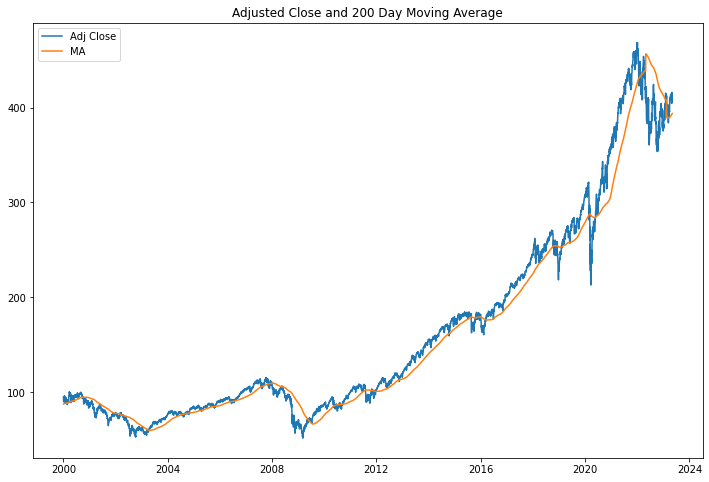

In [4]:
# 以下為2000年1月至2023年5月S&P 500 ETF價格走勢: 
plt.figure(figsize=(12, 8))
plt.plot(df['Adj Close'], label='Adj Close')
plt.plot(df['200_MA'], label='MA')
plt.title('Adjusted Close and 200 Day Moving Average')
plt.legend()
plt.show()

進場條件:
月底時，SPY的收盤價高於n天的移動平均，在下一個交易日以開盤價買入

出場條件:
月底時，SPY的收盤價低於n天的移動平均，在下一個交易日以開盤價賣出

In [4]:
# 200MA策略
df['Signal'] = 0
df['Position'] = 0
df['Held_Cash'] = 1.0
df['Held_Quantity'] = 0.0

# 從第一天開始遍歷
for i in range(len(df)-1):
    today = df.index[i]
    tomorrow = df.index[i+1]
    
    # 判斷是否是月底
    is_month_end = today.month != tomorrow.month
    
    # 月底時，SPY的收盤價高於n天的移動平均，在下一個交易日以開盤價買入
    if is_month_end and df.loc[today, 'Adj Close'] > df.loc[today, '200_MA'] and df.loc[today, 'Position'] == 0:
        df.loc[tomorrow, 'Signal'] = 1
        df.loc[tomorrow, 'Position'] = 1
        df.loc[tomorrow, 'Held_Quantity'] = df.loc[today, 'Held_Cash'] / df.loc[tomorrow, 'Open']
        df.loc[tomorrow, 'Held_Cash'] = 0.0
    # 月底時，SPY的收盤價低於n天的移動平均，在下一個交易日以開盤價賣出
    elif is_month_end and df.loc[today, 'Adj Close'] < df.loc[today, '200_MA'] and df.loc[today, 'Position'] == 1:
        df.loc[tomorrow, 'Signal'] = -1
        df.loc[tomorrow, 'Position'] = 0
        df.loc[tomorrow, 'Held_Cash'] = df.loc[today, 'Held_Quantity'] * df.loc[tomorrow, 'Open']
        df.loc[tomorrow, 'Held_Quantity'] = 0.0
    else:
        if i+1 < len(df):
            df.loc[tomorrow, 'Position'] = df.loc[today, 'Position']
            df.loc[tomorrow, 'Held_Quantity'] = df.loc[today, 'Held_Quantity']
            df.loc[tomorrow, 'Held_Cash'] = df.loc[today, 'Held_Cash']

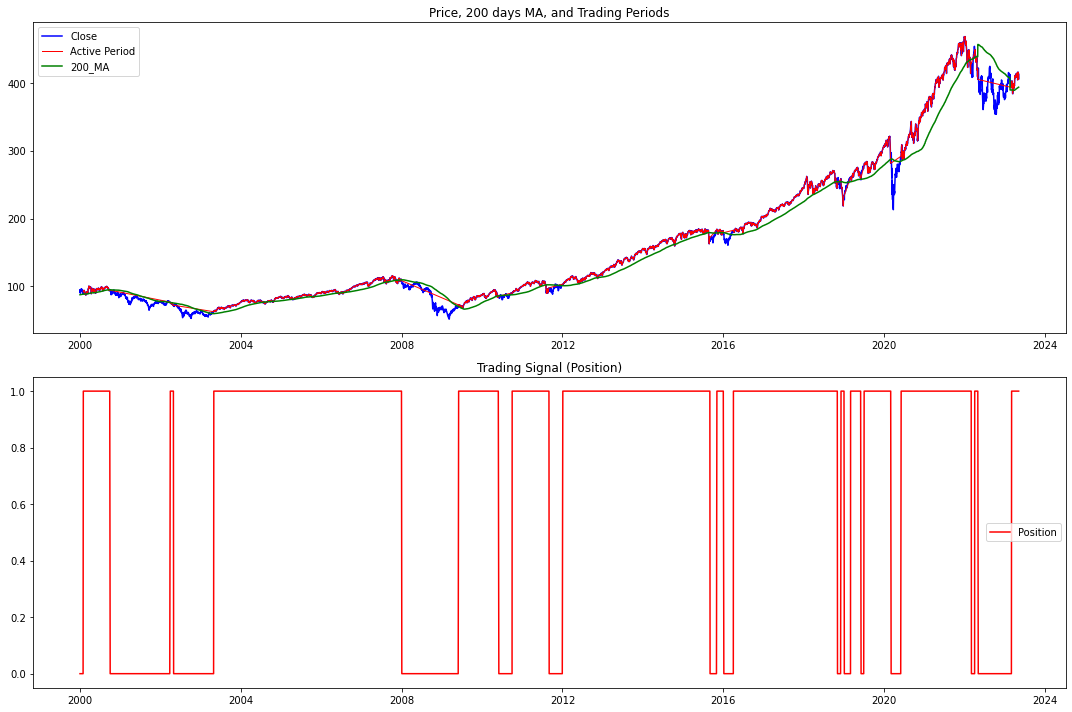

In [5]:
# 策略持倉視覺化:
# 其中，股價標示紅色線部分，代表正在持有這檔ETF，Trading Sign為產生進出場訊號，1代表進場，0代表空手。

fig = plt.figure(figsize=(15, 10))

# Subplot for the Adjusted Close, Active Period, and the 200-day Moving Average
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df['Adj Close'], label='Close', color='blue')
ax1.plot(df.loc[df['Position'] == 1, 'Adj Close'], label='Active Period',color='red', lw=1)
ax1.plot(df['200_MA'], label='200_MA', color='green')
ax1.set_title('Price, 200 days MA, and Trading Periods')
ax1.legend()

# Subplot for the trading signals
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(df['Position'], label='Position', color='r')
ax2.set_title('Trading Signal (Position)')
ax2.legend()

# Adjust the layout
plt.tight_layout()
plt.show()

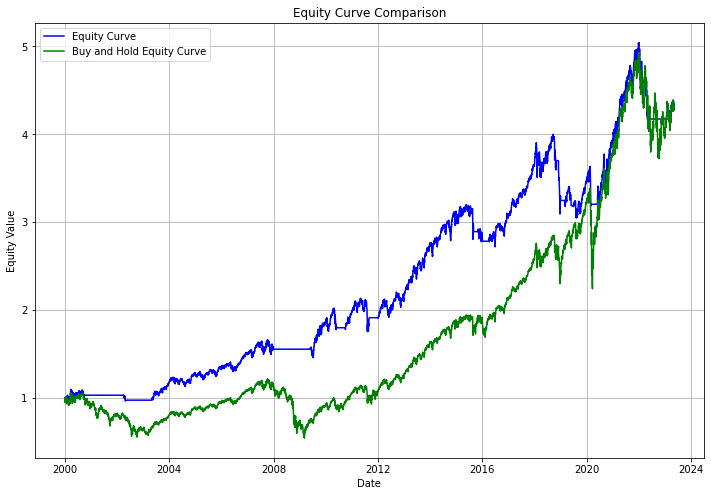

In [6]:
df['Equity Curve'] = df['Held_Cash'] + df['Held_Quantity'] * df['Close']
df['Equity Curve'].replace(0, np.nan, inplace=True)
df['Equity Curve'].fillna(method='ffill', inplace=True)

# 找到2000年1月1日後的第一個交易日
first_trading_day = df.index[0]

# 計算在第一個交易日買入的數量
initial_quantity = 1.0 / df.loc[first_trading_day, 'Adj Close']

# 計算每天的權益曲線
df['Buy and Hold Equity Curve'] = initial_quantity * df['Adj Close']  

# Plotting the Equity Curve
plt.figure(figsize=(12, 8))
plt.plot(df['Equity Curve'], label='Equity Curve', color='blue')
plt.plot(df['Buy and Hold Equity Curve'], label='Buy and Hold Equity Curve', color='green')
plt.title('Equity Curve Comparison')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.legend()
plt.grid()
plt.show()

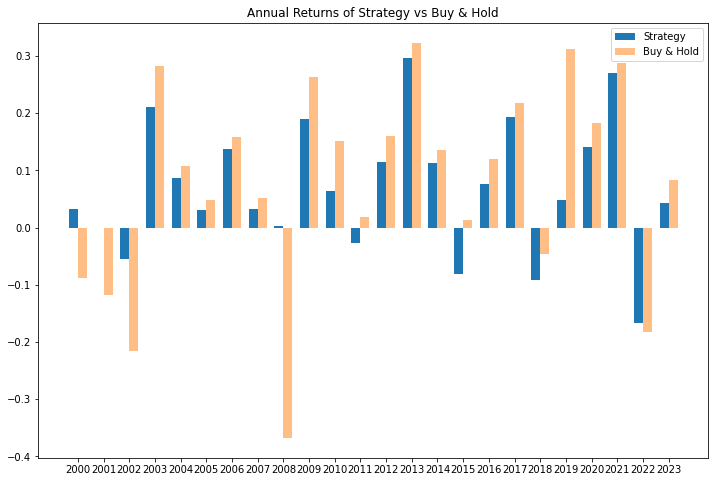

In [7]:
# 畫年化報酬柱狀圖
df['Strategy_Return'] = df['Equity Curve'].pct_change()
df['BH_Return'] = df['Buy and Hold Equity Curve'].pct_change()
df['Year'] = df.index.year

annual_strategy_returns = df.groupby('Year')['Strategy_Return'].apply(lambda x: (1 + x).prod() - 1)
annual_bh_returns = df.groupby('Year')['BH_Return'].apply(lambda x: (1 + x).prod() - 1)
bar_width = 0.35
bar_positions_strategy = np.arange(len(annual_strategy_returns.index))
bar_positions_bh = bar_positions_strategy + bar_width

plt.figure(figsize=(12, 8))
plt.bar(bar_positions_strategy, annual_strategy_returns, width=bar_width, label='Strategy')
plt.bar(bar_positions_bh, annual_bh_returns, width=bar_width, alpha=0.5, label='Buy & Hold')
plt.xticks(bar_positions_strategy + bar_width / 2, annual_strategy_returns.index)
plt.title('Annual Returns of Strategy vs Buy & Hold')
plt.legend()
plt.show()

In [8]:
# 計算年化SR
df['Strat Daily Returns'] = df['Equity Curve'].pct_change()
df['BuyHold Daily Returns'] = df['Buy and Hold Equity Curve'].pct_change()

# 计算策略的sharpe ratio
strat_sharpe_ratio = df['Strat Daily Returns'].mean() / df['Strat Daily Returns'].std() * np.sqrt(252)
print(f"Strategy Sharpe Ratio: {strat_sharpe_ratio}")

# 计算Buy and Hold的sharpe ratio
buyhold_sharpe_ratio = df['BuyHold Daily Returns'].mean() / df['BuyHold Daily Returns'].std() * np.sqrt(252)
print(f"Buy and Hold Sharpe Ratio: {buyhold_sharpe_ratio}")

Strategy Sharpe Ratio: 0.5833955569558187
Buy and Hold Sharpe Ratio: 0.4175079812403123


In [9]:
# 计算策略的drawdown
df['Strat Cumulative Returns'] = (1 + df['Strat Daily Returns']).cumprod()
df['Strat Running Max'] = df['Strat Cumulative Returns'].cummax()
df['Strat Drawdown'] = df['Strat Running Max'] - df['Strat Cumulative Returns']
df['Strat Drawdown Percent'] = df['Strat Drawdown'] / df['Strat Running Max']
max_strat_drawdown = df['Strat Drawdown Percent'].max()
print(f"Strategy Max Drawdown: {max_strat_drawdown}")

# 计算Buy and Hold的drawdown
df['BuyHold Cumulative Returns'] = (1 + df['BuyHold Daily Returns']).cumprod()
df['BuyHold Running Max'] = df['BuyHold Cumulative Returns'].cummax()
df['BuyHold Drawdown'] = df['BuyHold Running Max'] - df['BuyHold Cumulative Returns']
df['BuyHold Drawdown Percent'] = df['BuyHold Drawdown'] / df['BuyHold Running Max']
max_buyhold_drawdown = df['BuyHold Drawdown Percent'].max()
print(f"Buy and Hold Max Drawdown: {max_buyhold_drawdown}")

Strategy Max Drawdown: 0.23748607462489216
Buy and Hold Max Drawdown: 0.5518944196697931


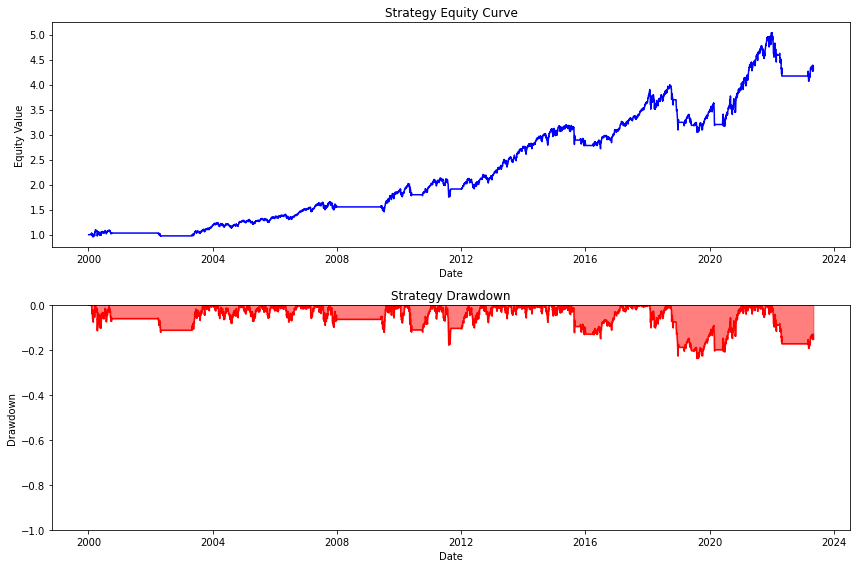

In [10]:
# 繪製策略 Equity Curve 和 Drawdown
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot Strategy Equity Curve
ax1.plot(df['Strat Cumulative Returns'], label='Equity Curve', color='blue')
ax1.set_title('Strategy Equity Curve')
ax1.set_xlabel('Date')
ax1.set_ylabel('Equity Value')

# Plot Strategy Drawdown
ax2.plot(-df['Strat Drawdown Percent'], label='Drawdown', color='red')
ax2.fill_between(df.index, -df['Strat Drawdown Percent'], color='red', alpha=0.5)
ax2.set_title('Strategy Drawdown')
ax2.set_xlabel('Date')
ax2.set_ylabel('Drawdown')
ax2.set_ylim(-1, 0)

plt.tight_layout()
plt.show()

TODO List
提升或改進策略的最終累積報酬

1. 引入更多的指標：嘗試加入更多的技術指標，如RSI，MACD等，來增加進出場的條件，以提高策略的表現。

2. 優化參數：嘗試修改現有指標的參數，例如200MA改成其他的天數，可能可以進行優化，但須考慮是否會發生overfitting問題。

3. 使用機器學習：嘗試使用機器學習方法來預測市場的變動，並根據預測結果來制定交易策略，但也須考慮overfitting問題。

4. 組合策略：可以嘗試將多個策略組合在一起，ex. Long Short S&P and Nasdaq，這可能有助於提高策略的績效並降低風險。